In [1]:
# import packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [2]:
# read in data
data = pd.read_csv('starcraft_player_data.csv')
data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


# Preprocessing and EDA

In [3]:
# calculate proportion of rows with missing values or nonnumeric values since all features are numeric
data = data.apply(lambda x: pd.to_numeric(x, errors='coerce'))
data.isna().sum() / len(data) * 100

GameID                  0.000000
LeagueIndex             0.000000
Age                     1.620029
HoursPerWeek            1.649485
TotalHours              1.678940
APM                     0.000000
SelectByHotkeys         0.000000
AssignToHotkeys         0.000000
UniqueHotkeys           0.000000
MinimapAttacks          0.000000
MinimapRightClicks      0.000000
NumberOfPACs            0.000000
GapBetweenPACs          0.000000
ActionLatency           0.000000
ActionsInPAC            0.000000
TotalMapExplored        0.000000
WorkersMade             0.000000
UniqueUnitsMade         0.000000
ComplexUnitsMade        0.000000
ComplexAbilitiesUsed    0.000000
dtype: float64

In [4]:
# since proportion of missing/nonnumeric values is small, I will just drop them
data = data.dropna()

In [5]:
# create feature called rank that records LeagueIndex <= 5 as low and League Index > 5 as high to allow for binary classification and simpler interpretation
# then dropped LeagueIndex
# also dropped GameID since it is a predictor that I can assume does not have an effect on the game (this also simplifies the model)
data['rank'] = np.where(data['LeagueIndex'] <= 5, 'low', 'high')
data = data.drop('LeagueIndex', axis=1)
data = data.drop('GameID', axis=1)

<Axes: title={'center': 'Count of Ranks'}, xlabel='rank'>

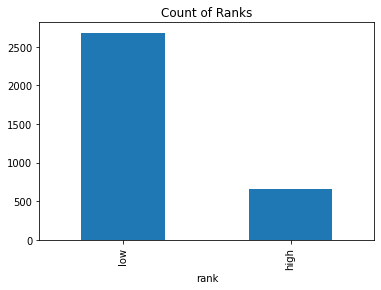

In [6]:
# look at distribution of ranks
data['rank'].value_counts().plot(kind='bar', title='Count of Ranks')

There are a lot more low rank players than high rank players in the dataset.

Text(0.5, 1.0, 'Distribution of TotalMapExplored by Rank')

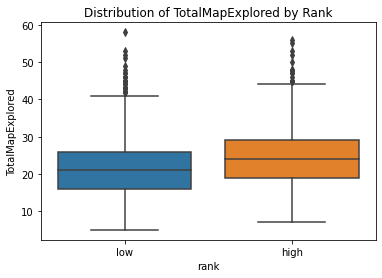

In [7]:
# look at distribution of TotalMapExplored by rank
sns.boxplot(data, x='rank', y='TotalMapExplored').set_title('Distribution of TotalMapExplored by Rank')

Higher rank players generally look at the map more.

Text(0.5, 1.0, 'Distribution of APM by Rank')

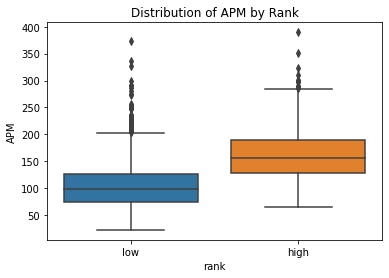

In [8]:
# look at distribution of APM by rank
sns.boxplot(data, x='rank', y='APM').set_title('Distribution of APM by Rank')

Higher ranks generally have a higher APM.

Text(0.5, 1.0, 'Distribution of Age by Rank')

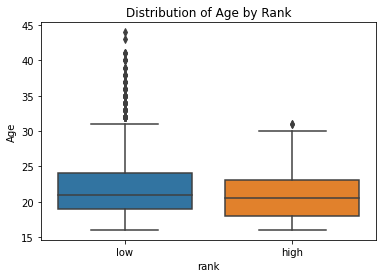

In [9]:
# look at distribution of age by rank
sns.boxplot(data, x='rank', y='Age').set_title('Distribution of Age by Rank')

There is no significant difference in age between high and low rank, but there is a greater amount of particularly older players in low rank. This makes sense when we consider the aging curve in gaming. 

Text(0.5, 1.0, 'Distribution of Number of PACs by Rank')

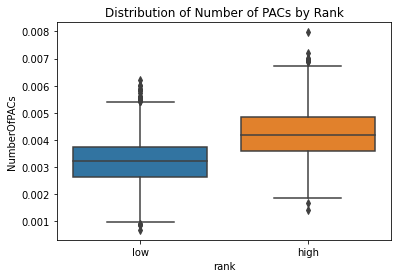

In [10]:
# look at distribution of number of PACs by rank and also actions in PC by rank
sns.boxplot(data, x='rank', y='NumberOfPACs').set_title('Distribution of Number of PACs by Rank')

Text(0.5, 1.0, 'Distribution of Actions in PAC by Rank')

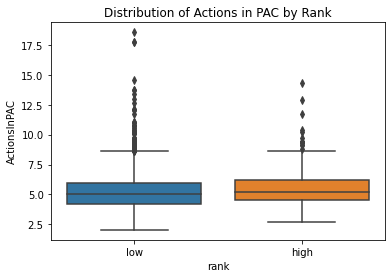

In [11]:
sns.boxplot(data, x='rank', y='ActionsInPAC').set_title('Distribution of Actions in PAC by Rank')

Higher ranks generally perform more PACs, but the number of actions in PACs is not significantly different between the two ranks. However, lower rank has a greater amount of players who have a particularly high amount of actions in PAC. This suggests that some low rank players display the level of skill seen in high rank players. 

In [12]:
# look at correlation between features
corr_data=data
corr_data['rank'] = np.where(corr_data['rank'] == 'low', 0, 1)
corr_data.corr()

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed,rank
Age,1.000000,-0.184431,-0.016630,-0.210724,-0.131105,-0.104960,0.015119,0.043100,-0.019904,-0.197128,0.112106,0.240240,-0.045893,-0.024191,-0.092291,0.022893,-0.080269,-0.065603,-0.111257
HoursPerWeek,-0.184431,1.000000,0.024306,0.246897,0.205792,0.158316,0.070262,0.084103,0.049498,0.174871,-0.133838,-0.188735,0.095271,0.064896,0.050679,0.038524,0.059285,0.074713,0.237550
TotalHours,-0.016630,0.024306,1.000000,0.072850,0.081830,0.042415,0.009318,0.000869,0.007662,0.039577,-0.020644,-0.035700,0.010704,0.020486,0.014828,-0.002379,-0.007154,-0.006311,0.001702
APM,-0.210724,0.246897,0.072850,1.000000,0.814624,0.534134,0.335986,0.218562,0.306392,0.635248,-0.567396,-0.722253,0.402928,0.239336,0.377719,0.122916,0.161774,0.141060,0.470403
SelectByHotkeys,-0.131105,0.205792,0.081830,0.814624,1.000000,0.450342,0.274030,0.132723,0.107615,0.360057,-0.273767,-0.390012,0.166964,0.097397,0.161404,0.027628,0.065467,0.063720,0.368282
AssignToHotkeys,-0.104960,0.158316,0.042415,0.534134,0.450342,1.000000,0.402555,0.205436,0.154998,0.454480,-0.377926,-0.461496,0.091508,0.201862,0.197011,0.149329,0.169849,0.169048,0.373870
UniqueHotkeys,0.015119,0.070262,0.009318,0.335986,0.274030,0.402555,1.000000,0.151029,0.124570,0.353112,-0.223745,-0.304583,-0.022227,0.267940,0.111319,0.233274,0.122352,0.110004,0.269662
MinimapAttacks,0.043100,0.084103,0.000869,0.218562,0.132723,0.205436,0.151029,1.000000,0.224683,0.137745,-0.213330,-0.171464,0.133712,0.164110,0.082283,0.125035,0.052225,0.042265,0.223087
MinimapRightClicks,-0.019904,0.049498,0.007662,0.306392,0.107615,0.154998,0.124570,0.224683,1.000000,0.143538,-0.244542,-0.216644,0.323707,0.173514,0.212464,0.154447,0.097992,0.095659,0.135147
NumberOfPACs,-0.197128,0.174871,0.039577,0.635248,0.360057,0.454480,0.353112,0.137745,0.143538,1.000000,-0.491407,-0.817162,-0.242571,0.470955,0.282204,0.322181,0.196269,0.177696,0.432700


APM and NumberOfPACs have the strongest positive correlation with rank. ActionsInPAC, UniqueUnitsMade, ComplexUnitsMade, and ComplexAbilitiesUsed have the weakest positive correlations with rank. Older age generally seems to be slightly related to slower actions but is not significantly related to rank. Also, interestingly enough, TotalMapExplored is moderately related to UniqueUnitsMade.

# Model Building

## Logistic Regression
I decided to build a logistic regression model, which is a popular model for binary classification.

In [13]:
# training and testing split while stratifying rank since there are less high rank players
x = data.drop(columns='rank')
y = data['rank']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, stratify=y, random_state=1114)

# standardize training data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# logistic regression
log_reg = LogisticRegression()
log_reg.fit(x_train_scaled, y_train)

LogisticRegression()

In [14]:
# model accuracy on training data
log_reg.score(x_train_scaled, y_train)

0.8565924657534246

In [15]:
# model accuracy on testing data
log_reg.score(x_test_scaled, y_test)

0.8363273453093812

Accuracy is quite high for training and testing data, and the values are similar. Therefore, there is not much overfitting going on, and the predictors do a good job of predicting rank. 

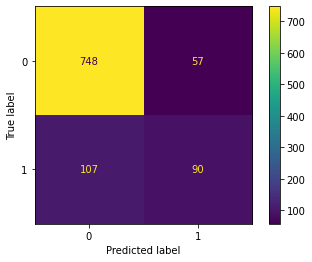

In [16]:
# logistic regression confusion matrix
y_pred = log_reg.predict(x_test_scaled)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_display.plot()
plt.show()

According to the confusion matrix, the logistic regression model fit to this dataset does a great job correctly predicting low rank players but not high rank players. The model predicts high rank players as low rank players slightly more frequently than correctly predicting them as high rank players. There is almost a 50/50 split between predicting high rank players as low rank and correctly predicting high rank players as high rank. 

## Random Forest
I also trained a random forest model to see if I could build a better performing model.

In [17]:
# random forest 
rf = RandomForestClassifier(n_estimators=4)
rf.fit(x_train_scaled, y_train)

RandomForestClassifier(n_estimators=4)

In [18]:
# model accuracy on training data
rf.score(x_train_scaled, y_train)

0.9610445205479452

In [19]:
# model accuracy on testing data
rf.score(x_test_scaled, y_test)

0.845309381237525

Both the training and testing accuracies are quite high, but the model seems to have overfit to the training data since its accuracy is higher than that of the testing data. 

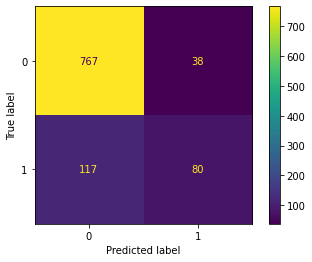

In [20]:
# random forest confusion matrix
y_pred = rf.predict(x_test_scaled)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_display.plot()
plt.show()

The random forest model does a good job at correctly predicting low rank players, but it struggles to predict high rank players correctly. It incorrectly predicts high rank players as low rank players almost twice as much as it correctly predicts them. Between the two models, I think I prefer the logistic regression model since it has less overfitting, higher testing accuracy, and less errors in correctly predicting high rank players. 

Unfortunately, due to the limited specifications of my laptop, I was unable to fully tune/optimize my models, so it is possible that I could have improved the performance of both models. The process would involve searching through a list of possible parameters for the model and selecting the values that optimize performance. 

# Findings

I built a logistic regression model that predicts a player's rank at about 84% accuracy using all of the variables in dataset except GameID. To simplify my workflow and interpretations, I grouped Bronze to Diamond as low rank and Master to Professional as high rank. Overall, the variables in the dataset do a decent job at predicting rank. 

The model does a good job at correctly predicting low rank players as low rank, but it struggles in correctly predicting high rank players as high rank. This may be due to the fact that there were many more low rank players in the dataset than high rank players. There are more low rank data for the model to base its predictions on compared to high rank data. It might also be due to some high rank players displaying values similar to those in Diamond. 

I believe the model can be improved by trimming down the number of variables with the help of someone who has more knowledge in Starcraft. For example, some of the variables in the dataset deal with the same concept (hotkeys, PAC, etc.), so it would be nice to extract the most important variable(s) out of them. This would help simplify our model. With a more powerful machine, I could also further optimize the models. 

One note I would like to mention as well is that even though it is commonly accepted that younger players would perform better, there does not seem to be that strong of a relationship between age and rank. Therefore, it would be incorrect to some extent to assume that older players are not as good as younger ones. Perhaps the tradeoff between age and experience works in older players' favors.

# Future Directions for Dataset

First, I would suggest trying to collect much more data on high rank players to balance out the dataset. If that is not possible, I would try to bootstrap the data. Also, like I mentioned above, I would suggest trimming down the list of variables to reduce noise in the dataset. That would decrease the amount of data needed to be collected as well. For example, I would assume NumberOfPACs would be indicative of GapBetweenPACs anyway since the duration between PACs would have to be shorter for more PACs to be performed. In this case, I would try to include only one of these variables. 

Also, seeing that the model struggles to correctly identify high rank players, I would suggest searching for another variable that would effectively indicate someone as high rank or engineer a new variable of our own. Either there is more information we can use to correctly identify high rank players, or there is a smaller difference between low rank players and high rank players than we would expect. For example, if possible, perhaps we could try to collect data on the number of unique build paths or strategies that player utilizes regularly. Using win rates might also be a good idea. 